<h1 align="center"> Tabular Data with PyTorch </h1>

In this notebook, I will explore PyTorch's capabilities to deal with tabular data. I will be solving a regression problem using fully connected feed forward neural networks. Then in 2nd section we will explore the models for classification problems as well. 

## Problem Statement - Regression

The goal is to estimate the cost of a New York City cab ride from several inputs. The inspiration behind this code along is a recent <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have developed on our own. However, to do this we have to handle categorical values separately from continuous ones.





## Imports


In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the Data

The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. 

For this exercise we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

In [4]:
df = pd.read_csv('../data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


*fare_amount attribute is our response variable*

## Exploratory data analysis(EDA)

In [5]:
fare_amt = df["fare_amount"]
fare_amt.describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from `$2.50` to `$49.90`, with a mean of `$10.04` and a median of `$7.70`

*Check shape of the data*

In [6]:
df.shape

(120000, 8)

There are 120K records and 8 attributes which includes both predictors and response variable.

*disply column and their type*

In [7]:
df.dtypes

pickup_datetime       object
fare_amount          float64
fare_class             int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

## Feature Engineering

This is the crucial part of any modeling problem. We need to use out intuition or domain expertise here. We can leverage the domain knowledge to create some custom features which can be very useful in deciding the fare(response attribute).

- In the intial data we have coordinates of pickup point and coordinates of dropoff point in latitude and logitude values. These values seperatly doesn't provide much information but when we use these points to calculate the distance between dropoff and pickup point, the distance plays vital role in determining the fare(response). 

- The time of day or day of a week also matter in deciding fares. In the dataset `pickup_time` all the information about day of the week, time of the day etc. We can create some additiona columns like whether it is weekdays or weekends or whether it is AM or PM etc.







### pickup and drop point distance calculations

We can use coordinates of source i.e `(pickup_latitude, pickup_longitude)` and destination coordinates i.e `(dropoff_latitude, dropoff_longitude)` to total journey distance.

To get the resultant distance using latitude and longitude points we can use <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> .

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{align} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{align}$


In [8]:
def haversine_distance(src_lat, src_long, trgt_lat, trgt_long):
    """
    (src_lat, src_long) -> coordinates of source point
    (trgt_lat, trgt_long) -> coordinates of target point
    Calculates the haversine distance between 2 sets of GPS coordinates in km
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(src_lat)
    phi2 = np.radians(trgt_lat)
    
    delta_phi = np.radians(trgt_lat-src_lat)
    delta_lambda = np.radians(trgt_long-src_long)
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [9]:
#append dist column

df['dist_km'] = df.apply(lambda x : haversine_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

In [10]:
df.head(3)

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763


### Decompose `pickup_datetime` column

The `pickup_datetime` contains information about date and time and day of the pickup which can be a deciding factor of fare like if it's weekend the fare might be a bit higher than the regular fare and so on.

By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [11]:
#create datetime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) - pd.Timedelta(hours=4)

In [12]:
#extrach hours
df['pickup_hour'] = df['pickup_datetime'].dt.hour
#append AMorPM depending on hour
df['AMorPM'] = np.where(df['pickup_hour']<12, 'am', 'pm')

#append weekday
df['Weekday'] = df['pickup_datetime'].dt.strftime("%a")

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,pickup_hour,AMorPM,Weekday
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,4,am,Mon
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,11,am,Sat
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,7,am,Sat
3,2010-04-11 17:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,17,pm,Sun
4,2010-04-16 22:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,22,pm,Fri


## Feature Selection

Now we have created some new columns that can play some role in deciding the final fare. Here we will be selecting a set of features that we will be using for modeling purposes. 

We also need to seggregate predictors and response into seperate buckets.

In [13]:
#features avaialble
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'pickup_hour', 'AMorPM', 'Weekday'],
      dtype='object')

We have already utilized `pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude` and `dropoff_latitude` columns. We can ignore them from further analysis.

In [14]:
#seggregate predictors and response
predictors = ['fare_class', 'passenger_count', 
              'dist_km', 'pickup_hour', 'AMorPM', 'Weekday']

#response
y_col = ['fare_amount']

In [15]:
#remove the unnecesary features

req_cols = predictors + y_col

df = df[req_cols]

## Feature encoding

Most of machine learning models need quantitative variables and they can't deal with quality(categorical) variable directlty.

If we have some categorical values in our data set, it is common practice to encode them in numbers before feeding them to models.

Let's look at the data type that we have in our data.

In [16]:
df.dtypes


fare_class           int64
passenger_count      int64
dist_km            float64
pickup_hour          int64
AMorPM              object
Weekday             object
fare_amount        float64
dtype: object

From above list we have `AmorPM` and `Weekday` as *catogorical* columns and rest are of *int* or *float* type which are acceptable.

Seggergate predictors into their data type i.e in category and continous data type.

In [17]:
#categorical columns
cat_cols = ['Weekday', 'AMorPM']

#numerical columns
cont_cols = ['fare_class', 'passenger_count', 'dist_km', 'pickup_hour']

**Dealing with category data in Pandas**

- Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. 
- A dataset containing months of the year will be assigned 12 codes, one for each month. 
- These will usually be the integers 0 to 11. 
- Pandas replaces the column values with codes, and retains an index list of category values.

In [18]:
#conver object data type to pandas category type

for cat_col in cat_cols:
    df[cat_col] = df[cat_col].astype('category')

In [19]:
df.dtypes

fare_class            int64
passenger_count       int64
dist_km             float64
pickup_hour           int64
AMorPM             category
Weekday            category
fare_amount         float64
dtype: object

`AMorPM` and `Weekday` has been type casted into pandas categorical data.

In [20]:
df[cat_cols].head(5)

,Weekday,AMorPM
0,Mon,am
1,Sat,am
2,Sat,am
3,Sun,pm
4,Fri,pm


We can access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This will make more sense if we look at <tt>df['AMorPM']</tt>:

In [21]:
df['AMorPM'].cat.codes.head()

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [22]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [23]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [24]:
df['Weekday'].cat.codes.head(5)

0    1
1    2
2    2
3    3
4    0
dtype: int8

Since `AMorPM` has only two distinct values `am` and `pm`. Converting them into categorical data has provided some additional methods like `.codes` and `.categories` which can be used to encode and decode the original values.

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine these two categorical columns into one input array.

For combining we can use <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a>.

Also we don't want series index, just the values are needed.

In [25]:
ampm = df['AMorPM'].cat.codes.values

weekdays = df['Weekday'].cat.codes.values

weekdays

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [26]:
#combine both arrays into a single variable
cat_values = np.stack([df[cat_col].cat.codes.values for cat_col in cat_cols], 1)

cat_values

array([[1, 0],
       [2, 0],
       [2, 0],
       ...,
       [3, 1],
       [5, 0],
       [2, 1]], dtype=int8)

Since we will be Modeling using PyTorch, we need to convert the ndarrays into tensors.

In [27]:
cats = torch.tensor(cat_values, dtype=torch.int64)

cats

tensor([[1, 0],
        [2, 0],
        [2, 0],
        ...,
        [3, 1],
        [5, 0],
        [2, 1]])

Since we can feed the continous variables into model directly so we wouldn't be encoding them.

Let's combine continous variables into a single variable like we combined categorical variable.

In [28]:
conts = np.stack([df[col].values for col in cont_cols], 1)

conts

array([[ 0.        ,  1.        ,  2.12631159,  4.        ],
       [ 0.        ,  1.        ,  1.39230687, 11.        ],
       [ 1.        ,  2.        ,  3.32676344,  7.        ],
       ...,
       [ 1.        ,  3.        ,  5.05252282, 14.        ],
       [ 0.        ,  1.        ,  1.20892296,  4.        ],
       [ 0.        ,  3.        ,  1.42739869, 12.        ]])

Convert it into tensor as well

In [29]:
#need to use batch normalization so it;s better to use float datatype
conts = torch.tensor(conts, dtype=torch.float32)
conts


tensor([[ 0.0000,  1.0000,  2.1263,  4.0000],
        [ 0.0000,  1.0000,  1.3923, 11.0000],
        [ 1.0000,  2.0000,  3.3268,  7.0000],
        ...,
        [ 1.0000,  3.0000,  5.0525, 14.0000],
        [ 0.0000,  1.0000,  1.2089,  4.0000],
        [ 0.0000,  3.0000,  1.4274, 12.0000]])

Convert response variable into tensor as well

In [30]:
df[y_col]

,fare_amount
0,6.5
1,6.9
2,10.1
3,8.9
4,19.7
...,...
119995,15.3
119996,15.3
119997,12.5
119998,4.9


In [31]:
#convert lable into tensor
y = torch.tensor(df[y_col].values, dtype=torch.float32).reshape(-1, 1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [32]:
#size of labels, cat cols and cont cols

print(f"labels shape : {y.shape}")
print(f"categorical df shape : {cats.shape}")
print(f"continuous shape : {conts.shape}")

labels shape : torch.Size([120000, 1])
categorical df shape : torch.Size([120000, 2])
continuous shape : torch.Size([120000, 4])


### Set embedding size

For categorical columns we will be using embedding layers and it resides in `nn.Embedding(ni, nf)`. `ni` is input dimension and `nf` is out dimension. input dimension is nothing but total number of distinct categories that you have in a column.

The rule of thumb for determining the embedding size(`nf`) is to divide the number of unique entries in each column by 2, but not to exceed 50.


In [33]:
cat_szs = [len(df[cat_col].cat.categories) for cat_col in cat_cols]

#set embedding size
emb_szs = [(sz, min((sz+1)//2, 50)) for sz in cat_szs]

emb_szs

[(7, 4), (2, 1)]

## Modeling

The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). 

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=green>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=green>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=green>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=green>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=green>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=green>def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

Let's explore the embedding steps.

In [34]:
catz = cats[:4]
catz

tensor([[1, 0],
        [2, 0],
        [2, 0],
        [3, 1]])

In [35]:
#create an embedding layers layers 

selfembd = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])

selfembd

ModuleList(
  (0): Embedding(7, 4)
  (1): Embedding(2, 1)
)

In [36]:
catz

tensor([[1, 0],
        [2, 0],
        [2, 0],
        [3, 1]])

In [37]:
cats

tensor([[1, 0],
        [2, 0],
        [2, 0],
        ...,
        [3, 1],
        [5, 0],
        [2, 1]])

In [38]:
#get embeddings for each categorical column
embeddings = []

for i, e in enumerate(selfembd):
    print(i)
    embeddings.append(e(cats[:, i]))

embeddings

0
1


[tensor([[-1.4258, -1.0346,  0.5828,  0.7813],
         [-0.3459, -1.8672,  0.1562,  0.9473],
         [-0.3459, -1.8672,  0.1562,  0.9473],
         ...,
         [-0.0574, -0.1937,  0.4837, -2.3578],
         [-1.7093, -1.5750, -0.9123, -0.0682],
         [-0.3459, -1.8672,  0.1562,  0.9473]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.2140],
         [-1.2140],
         [-1.2140],
         ...,
         [-1.0389],
         [-1.2140],
         [-1.0389]], grad_fn=<EmbeddingBackward0>)]

In [39]:
list(enumerate(selfembd))

[(0, Embedding(7, 4)), (1, Embedding(2, 1))]

In [40]:
#concat embeddings
z = torch.cat(embeddings, 1)
z

tensor([[-1.4258, -1.0346,  0.5828,  0.7813, -1.2140],
        [-0.3459, -1.8672,  0.1562,  0.9473, -1.2140],
        [-0.3459, -1.8672,  0.1562,  0.9473, -1.2140],
        ...,
        [-0.0574, -0.1937,  0.4837, -2.3578, -1.0389],
        [-1.7093, -1.5750, -0.9123, -0.0682, -1.2140],
        [-0.3459, -1.8672,  0.1562,  0.9473, -1.0389]], grad_fn=<CatBackward0>)

*Dropout layers*

In [41]:
selfembddrop = nn.Dropout(0.4)

z = selfembddrop(z)

z

tensor([[-0.0000, -0.0000,  0.0000,  0.0000, -2.0234],
        [-0.5765, -3.1120,  0.2603,  1.5789, -0.0000],
        [-0.5765, -3.1120,  0.0000,  1.5789, -2.0234],
        ...,
        [-0.0000, -0.3228,  0.0000, -3.9296, -0.0000],
        [-2.8488, -0.0000, -0.0000, -0.1137, -0.0000],
        [-0.0000, -0.0000,  0.2603,  1.5789, -1.7315]], grad_fn=<MulBackward0>)

It randomly drops or inactivated some of the values.

**Combine all the operations that we did above in a single notebook**

In [42]:
conts.shape

torch.Size([120000, 4])

In [112]:
#create a class

class SimpleTabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_szs, layers, p=0.5):

        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum([nf for ni, nf in emb_szs])
        n_in = n_emb + n_cont
        layerlist = []
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1], out_szs))

        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):

        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
        cat_x = torch.cat(embeddings, 1)
        #normalize continous values
        cont_x = self.bn_cont(x_cont)
        x = torch.cat([cat_x, cont_x], 1)
        x = self.layers(x)

        return x
        



In [113]:
torch.manual_seed(33)
model = SimpleTabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4) 

In [114]:
model

SimpleTabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(2, 1)
  )
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Total learnable paramerter in the above model.

In [115]:
total_params = 0

for param in model.parameters():
    total_params += param.numel()

print(f"Total Learniable Parameters are {total_params}")

Total Learniable Parameters are 22839


### Define loss function

Since here we are predicting fare amount and it is a continous value so this problem falls under regression.

We can use MSE loss function with <a href='https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss'><strong><tt>torch.nn.MSE()</tt></strong></a><br>


In [116]:
criterion = torch.nn.MSELoss()

### Define optimizer

Optimzer is need to update our parameters based on backpropagation. For the optimizer, I will be using <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>


In [117]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train, validation and test splits

In entire dataset we have around 120,000 records. We can adopt `70:15:15` division strategy to create train, test and validation set.

In [118]:
total_size = len(df)

train_size = int(0.7*total_size)
validation_size = int(0.15*total_size)
test_size = total_size - train_size - validation_size

cats_train = cats[:train_size]
conts_train = conts[:train_size]
y_train = y[:train_size]

m_valid = train_size
n_valid = train_size+validation_size
cats_valid = cats[m_valid:n_valid]
conts_valid = conts[m_valid:n_valid]
y_valid = y[m_valid:n_valid]

m_test = train_size+validation_size
n_test = train_size+validation_size+test_size
cats_test =  cats[m_test:n_test]
conts_test =  conts[m_test:n_test]
y_test =  y[m_test:n_test]

#display shapes
print(f"Training size of categorical, continuous and response variables : {cats_train.shape}, {conts_train.shape},{y_train.shape}")
print(f"Validation size of categorical, continuous and response variables : {cats_valid.shape}, {conts_valid.shape},{y_valid.shape}")
print(f"Test size of categorical, continuous and response variables : {cats_test.shape}, {conts_test.shape},{y_test.shape}")


Training size of categorical, continuous and response variables : torch.Size([84000, 2]), torch.Size([84000, 4]),torch.Size([84000, 1])
Validation size of categorical, continuous and response variables : torch.Size([18000, 2]), torch.Size([18000, 4]),torch.Size([18000, 1])
Test size of categorical, continuous and response variables : torch.Size([18000, 2]), torch.Size([18000, 4]),torch.Size([18000, 1])


In [119]:
conts_train

tensor([[ 0.0000,  1.0000,  2.1263,  4.0000],
        [ 0.0000,  1.0000,  1.3923, 11.0000],
        [ 1.0000,  2.0000,  3.3268,  7.0000],
        ...,
        [ 0.0000,  1.0000,  1.2522, 13.0000],
        [ 0.0000,  1.0000,  0.6299, 11.0000],
        [ 0.0000,  1.0000,  3.5523, 13.0000]])

### Training

In [120]:
y_train

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [ 4.1000],
        [ 4.1000],
        [ 6.9000]])

In [121]:
import time

start_time = time.time()

epochs  = 1000
train_losses = []
valid_losses = []
test_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cats_train, conts_train)
    train_loss = criterion(y_pred, y_train)
    train_losses.append(train_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {train_loss.item():10.8f}')

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    #check for validation loss
    with torch.no_grad():
        y_valid_pred = model(cats_valid, conts_valid)
        valid_loss = criterion(y_valid_pred, y_valid)
        valid_losses.append(valid_loss.item())

        y_test_pred = model(cats_test, conts_test)
        test_loss = criterion(y_test_pred, y_test)
        test_losses.append(test_loss.item())


    

# print the last line
print(f'epoch: {i:3}  loss: {train_loss.item():10.8f}')
 # print the time elapsed
print(f'\nDuration: {time.time() - start_time:.0f} seconds')



epoch:   1  loss: 155.46688843
epoch:  26  loss: 110.54431152
epoch:  51  loss: 100.30926514
epoch:  76  loss: 92.93183136
epoch: 101  loss: 84.27398682
epoch: 126  loss: 72.92871094
epoch: 151  loss: 59.68602371
epoch: 176  loss: 45.86885071
epoch: 201  loss: 33.39014816
epoch: 226  loss: 24.10573006
epoch: 251  loss: 17.82441521
epoch: 276  loss: 14.46062946
epoch: 301  loss: 12.68109703
epoch: 326  loss: 11.83611012
epoch: 351  loss: 11.45114136
epoch: 376  loss: 11.17293453
epoch: 401  loss: 10.80067730
epoch: 426  loss: 10.74126530
epoch: 451  loss: 10.32743263
epoch: 476  loss: 10.12501049
epoch: 501  loss: 9.96208668
epoch: 526  loss: 9.89420223
epoch: 551  loss: 9.67195606
epoch: 576  loss: 9.52415657
epoch: 601  loss: 9.44077969
epoch: 626  loss: 9.30479336
epoch: 651  loss: 9.16680622
epoch: 676  loss: 9.10017681
epoch: 701  loss: 8.90557289
epoch: 726  loss: 8.99007320
epoch: 751  loss: 8.87298775
epoch: 776  loss: 8.78133678
epoch: 801  loss: 8.73616505
epoch: 826  loss: 8.

## Plot the Loss function

*Train loss as function of epochs*

Text(0.5, 0, 'epoch')

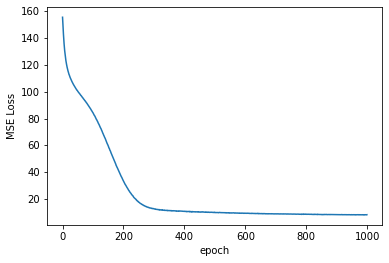

In [123]:
plt.plot(range(epochs), train_losses)
plt.ylabel('MSE Loss')
plt.xlabel('epoch')

*Train vs Validation loss*

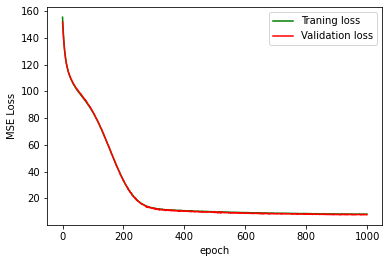

In [124]:
plt.plot(range(epochs), train_losses, 'g', label = 'Traning loss')
plt.plot(range(epochs), valid_losses, 'r', label = 'Validation loss')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()



*Train vs Validation vs Test loss function*

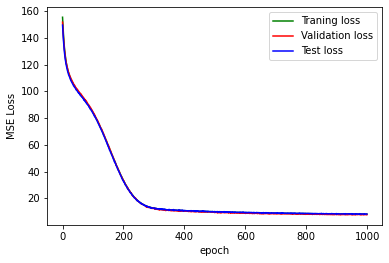

In [125]:
plt.plot(range(epochs), train_losses, 'g', label = 'Traning loss')
plt.plot(range(epochs), valid_losses, 'r', label = 'Validation loss')
plt.plot(range(epochs), test_losses, 'b', label = 'Test loss')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model's Inference

In [126]:
#set model in eval mode
model.eval()

#make grad as zero

with torch.no_grad():
    y_test_pred = model(cats_test, conts_test)
    loss = criterion(y_test_pred, y_test)

print(F"MSE loss on test set is : {loss}")


MSE loss on test set is : 6.7845282554626465
